# 机场高速数据测试简单处理 
### 采集时间：2022年8月31日下午
### 实验设计：6台仪器线性排布，间距20m,总长100m



In [11]:
import os
import obspy
from obspy import read,UTCDateTime
import matplotlib.pyplot as plt
import numpy as np

data_dir = 'data'
st = obspy.Stream()
for sacname in os.listdir(data_dir):
    st = st + read(os.path.join(data_dir,sacname))
st.filter('bandpass', freqmin=5, freqmax=120)

# modify time zone
for i in range(len(st)):
    st[i].stats.starttime = st[i].stats.starttime+8*3600
st

6 Trace(s) in Stream:
.EA000051..EHZ | 2022-08-31T17:40:00.000000Z - 2022-08-31T17:59:59.996073Z | 250.0 Hz, 300000 samples
.EA000057..EHZ | 2022-08-31T17:40:00.000000Z - 2022-08-31T17:59:59.996073Z | 250.0 Hz, 300000 samples
.EB000416..EHZ | 2022-08-31T17:40:00.000000Z - 2022-08-31T17:59:59.996073Z | 250.0 Hz, 300000 samples
.EB000598..EHZ | 2022-08-31T17:40:00.000000Z - 2022-08-31T17:59:59.996073Z | 250.0 Hz, 300000 samples
.EB000611..EHZ | 2022-08-31T17:40:00.000000Z - 2022-08-31T17:59:59.996073Z | 250.0 Hz, 300000 samples
.EB000623..EHZ | 2022-08-31T17:40:00.000000Z - 2022-08-31T17:59:59.996073Z | 250.0 Hz, 300000 samples

# 大概看一下全局波形，这里挑了10分钟左右，17：51~18:01，有倾斜的意思

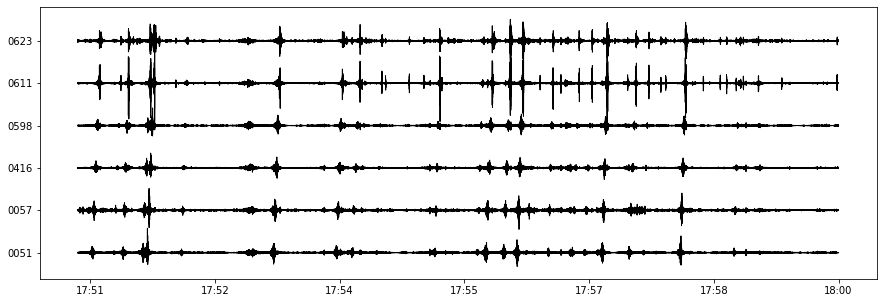

In [12]:
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
SECONDS_PER_DAY = 3600.0 * 24.0
formatter = DateFormatter('%H:%M')

cut_time = UTCDateTime(2022,8,31,17,51,25)
#cut_time = cut_time-8*3600
cut_start, cut_end = cut_time-12, cut_time+10*60
st_cut = st.slice(cut_start, cut_end)

# In[] plot waveform
plt.figure(figsize=(15,5))
ax = plt.subplot(111)
max_amp = np.max(np.abs(st_cut.max()))
trace_name = []
data = []
for i,tr in enumerate(st_cut):
    data_ = tr.data/max_amp   
    data.append(data_)
    x_values = ((tr.times() / SECONDS_PER_DAY) + date2num(tr.stats.starttime.datetime))
    ax.plot(x_values,data_+i,'k',linewidth=1)
    trace_name.append(tr.stats.station[4:])

ax.xaxis.set_major_formatter(formatter) 
ax.yaxis.set_ticks(np.arange(0,i+1, 1))
ax.set_yticklabels(trace_name)

data = np.array(data)

# 随机找一个大车的波形看一下，倾斜的非常好

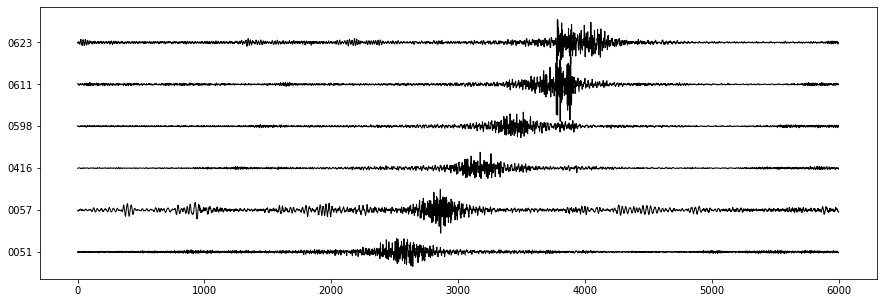

In [14]:
cut_time = UTCDateTime(2022,8,31,17,51,25)
cut_start, cut_end = cut_time-12, cut_time+12
st_cut = st.slice(cut_start, cut_end)

# In[] plot waveform
plt.figure(figsize=(15,5))
ax = plt.subplot(111)
max_amp = np.max(np.abs(st_cut.max()))
trace_name = []
data = []
for i,tr in enumerate(st_cut):
    data_ = tr.data/max_amp   
    data.append(data_)
    ax.plot(data_+i,'k',linewidth=1)
    trace_name.append(tr.stats.station[4:])
ax.yaxis.set_ticks(np.arange(0,i+1, 1))
ax.set_yticklabels(trace_name)

data = np.array(data)


# 确定一个模板信号（大概4s）,利用互相关计算到时差和汽车速度

[  77.25321888   50.56179775  120.80536913   68.44106464   66.66666667]
Mean velocity 70.8km/h


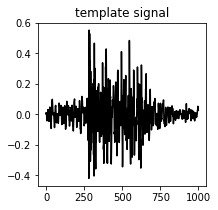

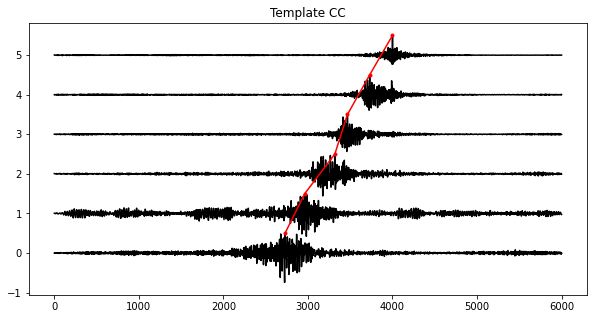

In [15]:
template = data[5,3500:4500]
plt.figure(figsize=(3,3))
plt.plot(template,'k')
plt.title('template signal')
#a = np.correlate(data[0,:],data[5,:],mode='same')

t,y = [],[]
plt.figure(figsize=(10,5))
for i in range(0,6):
    a = np.correlate(data[i,:],template,mode='same')
    plt.plot(a/a.max()/2+i,'k')
    pos = np.where(a==a.max())[0][0]
    plt.plot(pos,a[pos]/a.max()/2+i,'.r')
    y.append(a[pos]/a.max()/2+i)
    t.append(pos)
t,y = np.array(t),np.array(y)
plt.plot(t,y,'r')
plt.title('Template CC')

# polyfit

print(20/(t[1:]-t[:-1])*250*3.6)
v = 20/(np.mean(t[1:]-t[:-1])/250)*3.6
print('Mean velocity %.1fkm/h' % v)


# 如果用全部的6个台站来算，平均车速大概为71km/h,但是感觉后边三个台站互相关系数偏低。下面用前边3个台站（623,621,598）,最后确定速度大概为68km/h

[ 68.44106464  66.66666667]
Mean velocity 67.5km/h


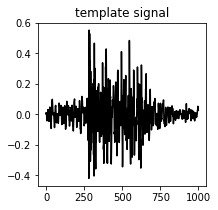

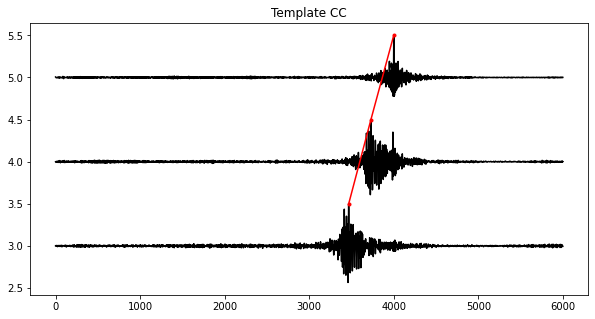

In [16]:
template = data[5,3500:4500]
plt.figure(figsize=(3,3))
plt.plot(template,'k')
plt.title('template signal')
#a = np.correlate(data[0,:],data[5,:],mode='same')

t,y = [],[]
plt.figure(figsize=(10,5))
for i in range(3,6):
    a = np.correlate(data[i,:],template,mode='same')
    plt.plot(a/a.max()/2+i,'k')
    pos = np.where(a==a.max())[0][0]
    plt.plot(pos,a[pos]/a.max()/2+i,'.r')
    y.append(a[pos]/a.max()/2+i)
    t.append(pos)
t,y = np.array(t),np.array(y)
plt.plot(t,y,'r')
plt.title('Template CC')

# polyfit

print(20/(t[1:]-t[:-1])*250*3.6)
v = 20/(np.mean(t[1:]-t[:-1])/250)*3.6
print('Mean velocity %.1fkm/h' % v)

# 能量图的形式

energy.mean = 0.000408 


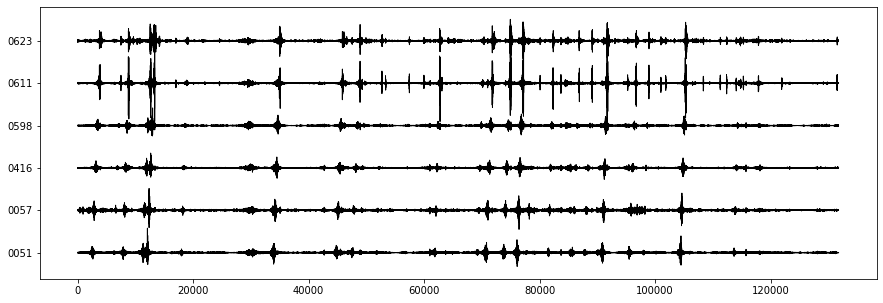

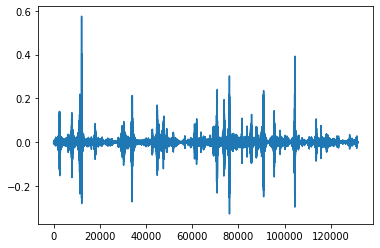

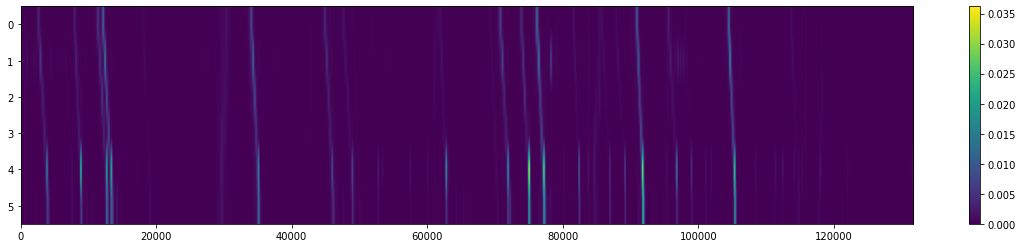

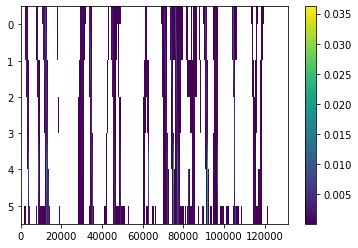

In [21]:
cut_time = UTCDateTime(2022,8,31,17,51,25)
cut_start, cut_end = cut_time-12, cut_time+10*60
st_cut = st.slice(cut_start, cut_end)

# In[] plot waveform
plt.figure(figsize=(15,5))
ax = plt.subplot(111)
max_amp = np.max(np.abs(st_cut.max()))
trace_name = []
data = []
for i,tr in enumerate(st_cut):
    data_ = tr.data/max_amp   
    data.append(data_)
    ax.plot(data_+i,'k',linewidth=1)
    trace_name.append(tr.stats.station[4:])
ax.yaxis.set_ticks(np.arange(0,i+1, 1))
ax.set_yticklabels(trace_name)

data = np.array(data)

def data2energy(d):
    k=125
    npts = len(d)
    e = np.zeros((npts))
    for i,amp in enumerate(d):
        if i>125 and i<npts-k:
            e[i] = np.sum(d[i-k:i+k]**2)
    e = e/(2*k+1)
    return e
            
        
plt.figure()
plt.plot(data[0,:])
plt.figure(figsize=(20,4))
energy = []
for i in range(0,6,1):
    energy.append(data2energy(data[i,:]))
energy = np.array(energy)

energy2 = energy.copy()

plt.imshow(energy[:,:],aspect='auto')
plt.colorbar()
print('energy.mean = %f ' % energy.mean())

plt.figure()
energy[energy<0.00005]=np.nan
plt.imshow(energy[:,:],aspect='auto')
plt.colorbar()


# 特殊路况：山区 山谷 隧道 涵洞 桥面

(200, 200)


F:\Software\Anoconda\Anoconda\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
F:\Software\Anoconda\Anoconda\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
F:\Software\Anoconda\Anoconda\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an a

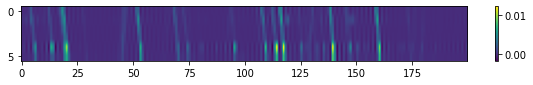

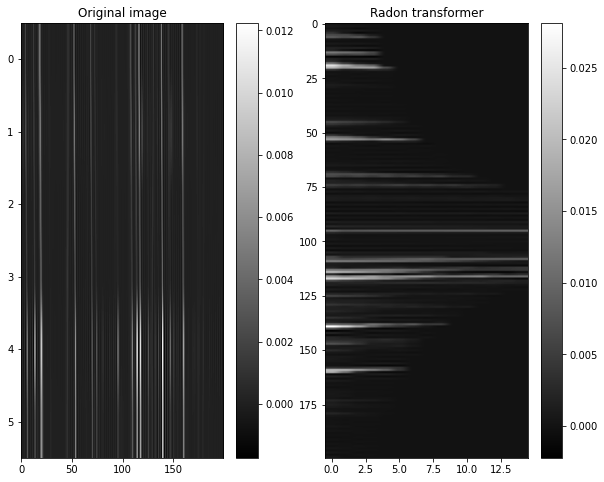

In [22]:
from scipy import ndimage,signal
import numpy as np
import matplotlib.pyplot as plt
import imageio
from cv2 import cv2


def DiscreteRadonTransform(image, steps):
    channels = len(image[0])
    res = np.zeros((channels, channels), dtype='float64')
    for s in range(steps):
        rotation = ndimage.rotate(image, -s*180/steps, reshape=False).astype('float64')
        #print(sum(rotation).shape)
        res[:,s] = sum(rotation)
    return res

plt.figure(figsize=(10,1))
#resampling
a = signal.resample(energy2,200,axis=1)
plt.imshow(a,aspect='auto')
plt.colorbar()

#image = cv2.imread("ct.png", cv2.IMREAD_GRAYSCALE)
image = a
radon = DiscreteRadonTransform(image, len(image[0]))
print(radon.shape)

#绘制原始图像和对应的sinogram图
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray',aspect='auto')
plt.colorbar()
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(radon[:,:15], cmap='gray',aspect='auto')
plt.colorbar()
plt.title('Radon transformer')
plt.show()

# 考虑倾斜滤波 FK滤波 radon变换

(200, 200)


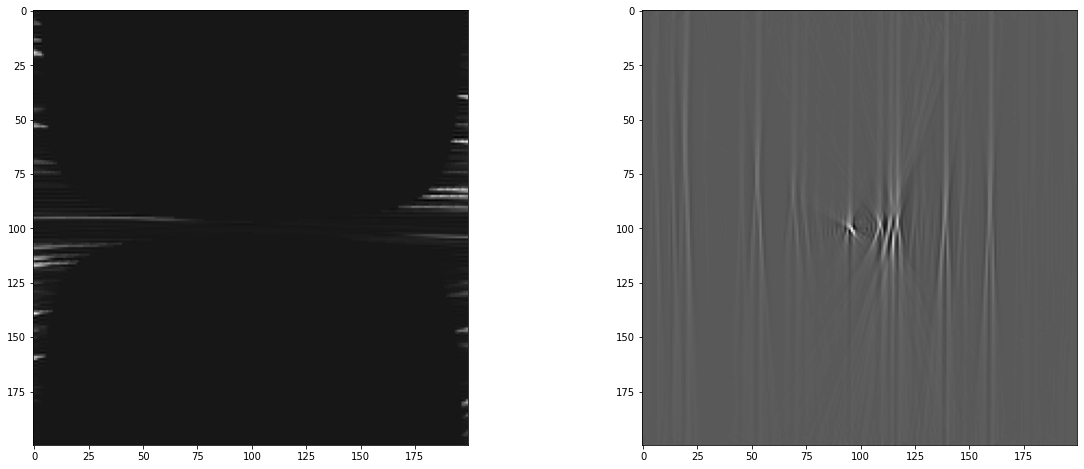

In [23]:
import numpy as np
from scipy import ndimage
from scipy.signal import convolve
import matplotlib.pyplot as plt
import imageio
from cv2 import cv2

#两种滤波器的实现
def RLFilter(N, d):
    filterRL = np.zeros((N,))
    for i in range(N):
        filterRL[i] = - 1.0 / np.power((i - N / 2) * np.pi * d, 2.0)
        if np.mod(i - N / 2, 2) == 0:
            filterRL[i] = 0
    filterRL[int(N/2)] = 1 / (4 * np.power(d, 2.0))
    return filterRL

def SLFilter(N, d):
    filterSL = np.zeros((N,))
    for i in range(N):
        #filterSL[i] = - 2 / (np.power(np.pi, 2.0) * np.power(d, 2.0) * (np.power((4 * (i - N / 2)), 2.0) - 1))
        filterSL[i] = - 2 / (np.pi**2.0 * d**2.0 * (4 * (i - N / 2)**2.0 - 1))
    return filterSL

def IRandonTransform(image, steps):
    #定义用于存储重建后的图像的数组
    channels = len(image[0])
    origin = np.zeros((steps, channels, channels))
    #filter = RLFilter(channels, 1)
    filter = SLFilter(channels, 1)
    for i in range(steps):
        projectionValue = image[:, i]
        projectionValueFiltered = convolve(filter, projectionValue, "same")
        projectionValueExpandDim = np.expand_dims(projectionValueFiltered, axis=0)
        projectionValueRepeat = projectionValueExpandDim.repeat(channels, axis=0)
        origin[i] = ndimage.rotate(projectionValueRepeat, i*180/steps, reshape=False).astype(np.float64)
    iradon = np.sum(origin, axis=0)
    return iradon

#读取图片
# image = cv2.imread("radonshepplogan.png", cv2.IMREAD_GRAYSCALE)
print(radon.shape)
#image = signal.resample(radon,200)
image = radon
iradon = IRandonTransform(image, len(image[0]))
#绘制原始图像和对应的sinogram图
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(iradon, cmap='gray')
plt.show()
